**7장 – 앙상블 학습과 랜덤 포레스트**

# 설정

- 맷플롯립 그래프를 인라인으로 출력하고 그림 저장하는 함수
- 파이썬 버전이 3.5 이상 여부 확인 
- 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [73]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)         # 결과: sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)) 
print("PY ver: ", sys.version_info)

# 사이킷런 ≥0.20 필수                         
import sklearn
assert sklearn.__version__ >= "0.20"      # 결과: '1.0.2'
print("sklearn ver: ", sklearn.__version__)

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

PY ver:  sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
sklearn ver:  1.0.2


# 투표기반 분류기

In [74]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32) 
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

- coin_tosses: 균등분포에서 샘플 10000개를 10번 생성하고 heads_proba 비교한 후(크면 True, 작은면 False) 정수로 변환 (10000 x 10 array)
- cumulattive_head_ratio: 열방향으로 누적하고 매 열에 맞춰 나누어서 확률을 구한함(?)

**<그림 7-3. 큰 수의 법칙> 생성 코드**

그림 저장: law_of_large_numbers_plot


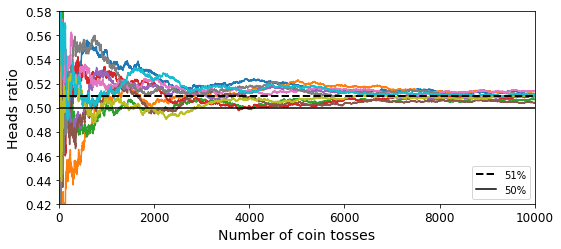

In [75]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
# plt.plot(cumulative_heads_ratio[:,0:2])                            # 첫 3개 열만 나타내기 
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")  # y축 51%에 점선으로 선 긋기 (검정) 
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")                  # y축 0.5에 실선 긋기(검정)
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

그림 저장: law_of_large_numbers_plot


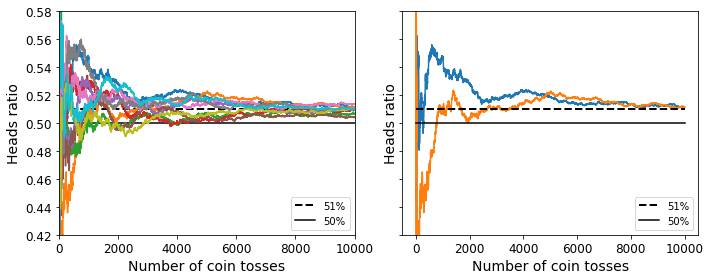

In [120]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")  # y축 51%에 점선으로 선 긋기 (검정) 
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")                  # y축 0.5에 실선 긋기(검정)
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.plot(cumulative_heads_ratio)

plt.sca(axes[1])
plt.plot(cumulative_heads_ratio[:,0:2])    
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")  # y축 51%에 점선으로 선 긋기 (검정) 
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")                  # y축 0.5에 실선 긋기(검정)
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")                   # 첫 3개 열만 나타내기 

save_fig("law_of_large_numbers_plot")
plt.show()


In [76]:
# scipy 이항분포로 계산
from scipy.stats import binom
print(1 - binom.cdf(499, 1000, 0.51))   # 앞면에 나올 확률 p = 0.51, 1000번 시행했을때 앞면이 501 이상이 될 확률
print(1 - binom.cdf(4999, 10000, 0.51)) # 10000번 시행

0.7467502275563249
0.9777976478701103


데이터셋: make_moons 데이터 500개(noise = 0.3) 사용 

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**코드 예제:** 랜덤포레스터, 로지스틱회귀, 서포터벡터 모델 사용  
- _2개를 사용하면?_ --> (0,1), (1,0)의 결정은? lr + svc: 0.856으로 나빠짐, lr + rf: 0.856, rf + svc: 0.88
- _5개를 사용하면?_ --> 더 좋아지는지?
  
**<노트>**: 향후 버전을 위해 사이킷런에서 기본 값이 될 `solver="lbfgs"`, `n_estimators=100`, `gamma="scale"`로 지정

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    # estimators=[('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [79]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [80]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    # clf.score(...)를 사용해도 됨
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [83]:
# 위 코드와 동일한 결과: voting_clf가 3개 예측기에 대한 훈련된 결과를 가지고 있음
for clf in voting_clf.estimators_+[voting_clf]:       # voting_clf.estimators_ 훈련된 객체 리스트로 포함
    print(clf.__class__.__name__, clf.score(X_test, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


간접 투표:

In [99]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)      # SVC는 predict_proba() method 제공 안함 --> probablity = True 설정

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

In [100]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


_참고) 2개만 voting하는 경우 결과: lr + rf : 0.912, rf + svm: 0.904, lr + svm: 0.888_  


# 배깅(Bootstrap Aggregating)과 페이스팅

## 사이킷런의 배깅과 페이스팅

In [110]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,              # DecisionTreeClassifier(random_state=42)와의 차이는?
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [111]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [112]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


(참고) 개별 DecisionTreeClassifier()의 accuracy score는  차이가 나지만 BaggingClassifier를 적용할 경우 500개의 예측기를 통과하기 때문에 차이가 거의 없음

**<그림 7-5. 단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교> 생성 코드**

In [114]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:                                                            # 경계선 그리는 코드
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

그림 저장: decision_tree_without_and_with_bagging_plot


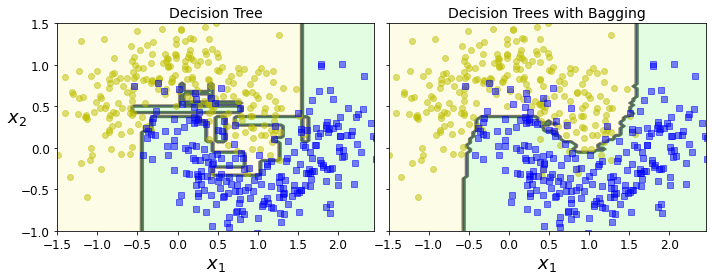

In [115]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## OOB(Out Of Bag) 평가
- Bootstrap에서는 일반적으로 37% 정도는 훈련 데이터로 사용되지 않음(OOB)
- OOB 데이터를 테스트 셋로 활용할 수 있음: 매개변수 `oob_score = True`

In [141]:

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
print('train_score', bag_clf.score(X_train, y_train))
print('oob_score', bag_clf.oob_score_)

train_score 1.0
oob_score 0.8986666666666666


In [144]:
print(bag_clf.oob_decision_function_[0:10,:])
print(bag_clf.oob_decision_function_.shape)

[[0.32275132 0.67724868]
 [0.34117647 0.65882353]
 [1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.09497207 0.90502793]
 [0.31147541 0.68852459]
 [0.01754386 0.98245614]
 [0.97109827 0.02890173]
 [0.97765363 0.02234637]]
(375, 2)


In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

# 랜덤 포레스트 
- Bootstrap + features 후보 선택 (features 개수: `sqrt(n_features)`)  ==> feature 2개인 이 경우는?
- n_jobs = -1 설정 추천

In [132]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print('accuracy_score of rf', accuracy_score(y_test, y_pred_rf))

accuracy_score of rf 0.912


In [133]:
rnd_clf.feature_importances_

array([0.42253629, 0.57746371])

랜덤 포레스트는 결정 트리의 배깅과 비슷합니다:

In [124]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [128]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print('accuracy_score of bagging', accuracy_score(y_test, y_pred))

accuracy_score of bagging 0.912


In [129]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

1.0

## 특성 중요도 (iris 데이터셋 이용)

In [135]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [136]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

다음 그림은 15개 결정 트리의 결정 경계를 중첩한 것입니다.   
여기서 볼 수 있듯이 개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만듬

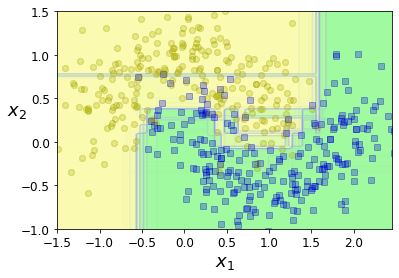

In [137]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

개별 결정트리 15개를 사용한 위의 경우와 RandomForest로 15개 예측기를 사용한 다음 경우 유사한 결과를 볼수 있음

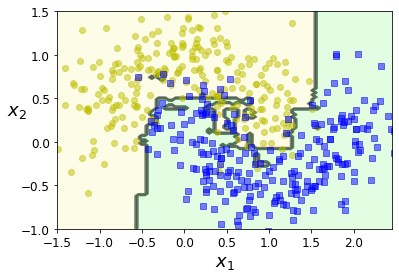

In [139]:
rf = RandomForestClassifier(n_estimators=15, random_state=42)
rf.fit(X_train, y_train)
plot_decision_boundary(rf, X, y, axes = [-1.5, 2.45, -1.0, 1.5])
plt.show()

**<그림 7-6. (랜덤 포레스트 분류기에서 얻은) MNIST 픽셀 중요도> 생성 코드**

In [145]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [146]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [147]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

그림 저장: mnist_feature_importance_plot


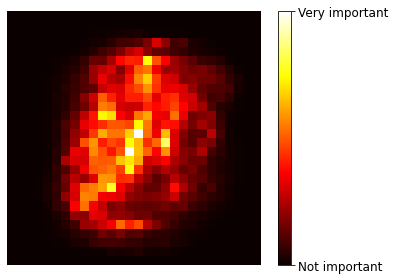

In [148]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# 부스팅  

- GBM이 가장 많이 사용되고 좋은 성능을 보이는 부스팅 앙상블 알고리즘  
- 순차적으로 에러 데이터를 훈련 데이터로 사용하기 때문에 병렬처리는 안됨

## 에이다부스트



In [149]:
from sklearn.ensemble import AdaBoostClassifier
# DecisionTreeClassifier의 경우 max_depth default = 1, Regressor: max_depth = 3
# SAMME.R -> R 실수 의미 --> 분류기가 확률을 제공할 경우 확률을 사용
# 학습률: 예측기가 뒤로 갈수록 가중치를 낮추는 효과

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,           
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

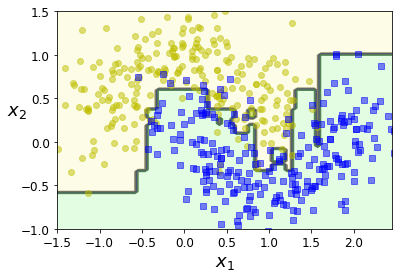

In [150]:
plot_decision_boundary(ada_clf, X, y)

**<그림 7-8. 연속된 예측기의 결정 경계> 생성 코드**

그림 저장: boosting_plot


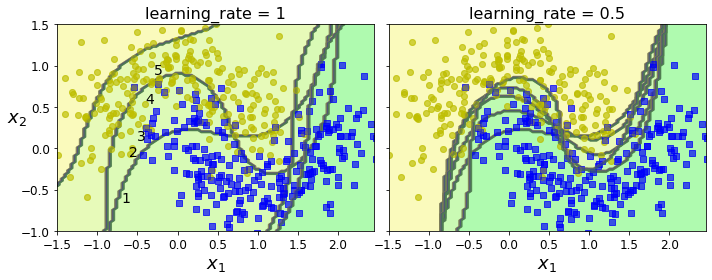

In [151]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)     # svm은 샘플의 가중치 조정 가능
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)                         # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)                  # equation 7-3
        sample_weights /= sample_weights.sum()                              # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

# 그레이디언트 부스팅

- 이차식 형태의 데이터셋 생성

In [165]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5                    # -0.5 ~ +0.5
y = 3*X[:,0]**2 + 0.05 * np.random.randn(100)      # ? 3*X**2와의 차이는? --> 100 X 1, 1 X 100
print(X.round(2)[0:10])
print(y.round(2))

[[-0.13]
 [ 0.45]
 [ 0.23]
 [ 0.1 ]
 [-0.34]
 [-0.34]
 [-0.44]
 [ 0.37]
 [ 0.1 ]
 [ 0.21]]
[ 0.05  0.59  0.17 -0.07  0.34  0.37  0.66  0.38 -0.01  0.1   0.74  0.68
  0.31  0.27  0.31  0.35  0.08 -0.01 -0.01  0.06  0.05  0.4   0.13  0.04
 -0.06  0.22  0.25 -0.04  0.02  0.64  0.13  0.33  0.58  0.6   0.55  0.28
  0.12  0.61  0.09  0.03  0.43 -0.06  0.71  0.54  0.21  0.03  0.18 -0.07
  0.04  0.41  0.61  0.2   0.58  0.44 -0.05  0.54  0.45  0.3   0.57  0.17
 -0.    0.14  0.36  0.    0.16  0.07  0.31  0.28  0.56  0.75  0.16  0.21
  0.76  0.31  0.14  0.17  0.19  0.56  0.07  0.41  0.49  0.07  0.03  0.6
  0.06  0.13  0.22  0.02  0.5   0.02  0.48  0.23  0.19 -0.03  0.18 -0.04
 -0.    0.03  0.69  0.5 ]


- 데이터셋에 결정 트리 회귀 모델을 훈련

In [166]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [167]:
y2 = y - tree_reg1.predict(X)                                       # 잔차 계산
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)                                                # Target을 잔차 y2로 변경

DecisionTreeRegressor(max_depth=2, random_state=42)

In [168]:
y3 = y2 - tree_reg2.predict(X)                                       # 잔차 계산
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)                                                 # Target을 잔차 y3로 변경

DecisionTreeRegressor(max_depth=2, random_state=42)

In [169]:
X_new = np.array([[0.8]])

In [170]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [171]:
y_pred

array([0.75026781])

**<그림 7-9> 생성 코드**

In [172]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

그림 저장: gradient_boosting_plot


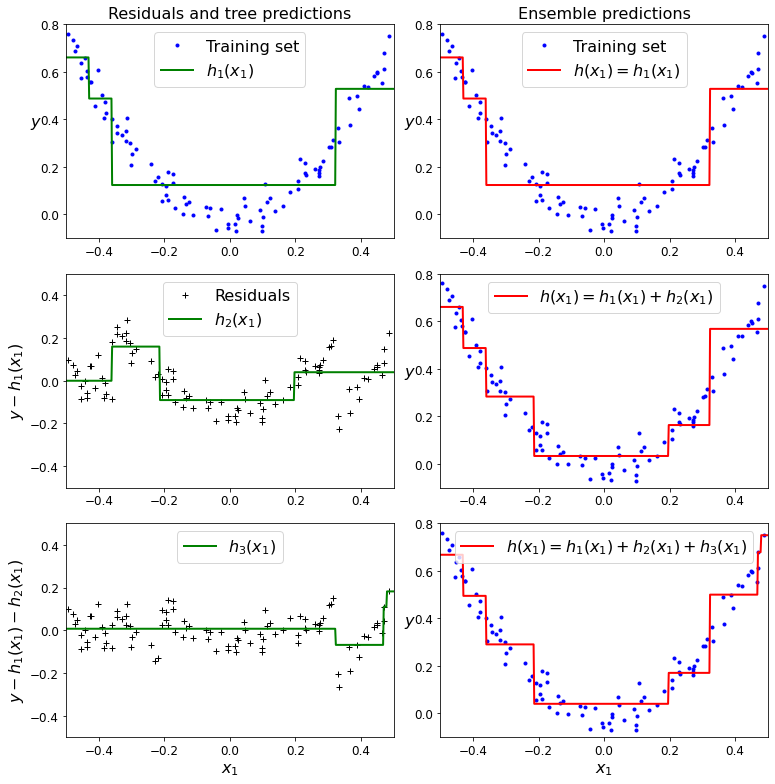

In [173]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

이제 그레이디언트 부스팅 회귀 모델을 사용해 보죠:

In [174]:
# 기반 모델은 DecisionTreeRegressor로 고정
# gradient: 손실함수 미분 --> target - pred 
# GradientBoostingRegressor 손실함수: 'lse', GradientBoostingClassifier 손실함수: 'devience'

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

**<그림 7-10. 예측기가 부족한 경우(왼쪽)과 너무 많은 경우(오른쪽)의 GBRT 앙상블> 생성 코드**

In [175]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

그림 저장: gbrt_learning_rate_plot


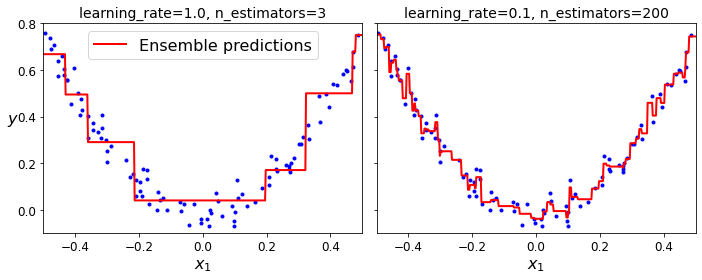

In [176]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

**조기 종료를 사용한 그래디언트 부스팅**
- staged_predict() method
- 매개 변수 사용 warm_start =  True

In [177]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]      # 매단계마다 MSE 구함
bst_n_estimators = np.argmin(errors) + 1                 # 가장 error가 작은 인덱스를 구함

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

**<그림 7-11. 조기 종료를 사용하여 트리 수 튜닝> 생성 코드**

In [178]:
min_error = np.min(errors)

그림 저장: early_stopping_gbrt_plot


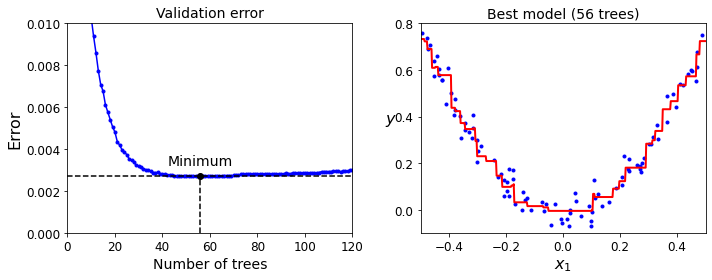

In [179]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

어느 정도 유예를 갖는 조기 종료(5 에포크 동안 향상되지 않을 때만 훈련 중지):

In [180]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [181]:
print(gbrt.n_estimators)

61


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**XGBoost 사용하기**
XGBoost 라이브러리 사용: histogram 기반 Boost 알고리즘

In [184]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [185]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [187]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42)   # n_estimator = 100, max_depth = 3
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

Validation MSE: 0.004000408205406276


In [188]:
# 조기 종료 early_stopping_rounds

if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


c:\Users\edmin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [196]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train)

18.8 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [197]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

10.7 ms ± 80.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 마이크로소프트 lightgbm 라이브러리

In [192]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [194]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
val_error

0.01777549654697777

In [195]:
%timeit LGBMRegressor().fit(X_train, y_train)

7.18 ms ± 133 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [199]:
# (0.21버전부터) scikit learn histogram 기반 부스팅 알고리즘 지원 
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [200]:
hgb_reg = HistGradientBoostingRegressor(random_state=42)
hgb_reg.fit(X_train, y_train)

y_pred = hgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
val_error

0.0158081410814983

In [201]:
%timeit HistGradientBoostingRegressor().fit(X_train, y_train)

36.5 ms ± 740 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 투표 기반 분류기

문제: _MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플)._

MNIST 데이터셋은 앞에서 로드했습니다.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

문제: _그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분류기를 훈련시킵니다._

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [ ]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [ ]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9692, 0.9715, 0.859, 0.9666]

선형 SVM이 다른 분류기보다 성능이 많이 떨어집니다. 그러나 투표 기반 분류기의 성능을 향상시킬 수 있으므로 그대로 두겠습니다.

문제: _그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요._

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [ ]:
voting_clf = VotingClassifier(named_estimators)

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.score(X_val, y_val)

0.9708

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9666]

SVM 모델을 제거해서 성능이 향상되는지 확인해 보죠. 다음과 같이 `set_params()`를 사용하여 `None`으로 지정하면 특정 예측기를  제외시킬 수 있습니다:

In [ ]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

예측기 목록이 업데이트되었습니다:

In [ ]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

하지만 훈련된 예측기 목록은 업데이트되지 않습니다:

In [ ]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

`VotingClassifier`를 다시 훈련시키거나 그냥 훈련된 예측기 목록에서 SVM 모델을 제거할 수 있습니다:

In [ ]:
del voting_clf.estimators_[2]

`VotingClassifier`를 다시 평가해 보죠:

In [ ]:
voting_clf.score(X_val, y_val)

0.9741

훨씬 나아졌네요! SVM 모델이 성능을 저하시켰습니다. 이제 간접 투표 분류기를 사용해 보죠. 분류기를 다시 훈련시킬 필요는 없고 `voting`을 `"soft"`로 지정하면 됩니다:

In [ ]:
voting_clf.voting = "soft"

In [ ]:
voting_clf.score(X_val, y_val)

0.972

이 경우는 직접 투표 방식이 낫네요.

_앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?_

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.971

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9645, 0.9691, 0.9643]

여기서는 투표 기반 분류기가 최선의 모델의 오차율을 아주 조금만 감소시킵니다.

## 9. 스태킹 앙상블

문제: _이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요._

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [ ]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.9707

이 블렌더를 세밀하게 튜닝하거나 다른 종류의 블렌더(예를 들어, `MLPClassifier`)를 시도해 볼 수 있습니다. 그런 늘 하던대로 다음 교차 검증을 사용해 가장 좋은 것을 선택합니다.

문제: _축하합니다. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?_

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [ ]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_pred)

0.9695

이 스태킹 앙상블은 앞서 만든 투표 기반 분류기만큼 성능을 내지는 못합니다. 최선의 개별 분류기만큼 뛰어나지는 않습니다.